In [1]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


Files already downloaded and verified
Files already downloaded and verified


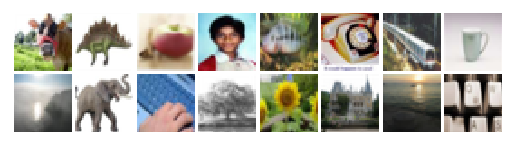

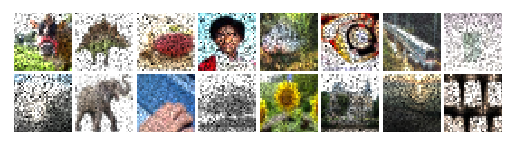

In [2]:
def add_noise(x):
    noise_amount = 0.1+0.3 * torch.rand(len(x)).to(device)
    noised = torch.normal(
       mean=torch.ones([1, 1, *x.shape[2:]], device=device),
       std=noise_amount.view(len(x), 1, 1, 1))
    return torch.clamp(x*noised, 0.0, 1.0)


traindata = datasets.CIFAR100('data', train=True, download=True, transform=transforms.ToTensor())
testdata = datasets.CIFAR100('data', train=False, download=True, transform=transforms.ToTensor())
dataloader = torch.utils.data.DataLoader(traindata, batch_size=16)

for x, y in dataloader:
    x = x.to(device)
    break

def plot_imgs(x):
    plt.figure()
    plt.imshow(np.transpose(vutils.make_grid(x[:16].cpu(),
        padding=2, pad_value=1, normalize=True), (1, 2, 0)),
                interpolation='nearest')
    plt.axis("off")
    plt.show()

plot_imgs(x)
plot_imgs(add_noise(x))

In [3]:
def conv3(n_in, n_out):
    return torch.nn.Conv2d(n_in, n_out, 3, padding=1)

def deconv4(n_in, n_out):
    return torch.nn.ConvTranspose2d(n_in, n_out, 4, 2, 1)

def relu(x):
    return F.relu(x, inplace=True)

def pool(x):
    return F.max_pool2d(x, 2, 2)

def concat(a, b):
    return torch.cat((a, b), 1)

class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.ec0 = 8
        self.ec1 = 16
        self.c2 = 32
        self.dc1 = 16
        self.dc0 = 8
        self.econv0 = conv3(3, self.ec0)
        self.econv1 = conv3(self.ec0, self.ec1)
        self.cconv1 = conv3(self.ec1, self.c2)
        self.cconv2 = conv3(self.c2, self.c2)
        self.deconv1 = deconv4(self.c2, self.dc1)
        self.dconv11 = conv3(self.ec1+self.dc1, self.dc1)
        self.dconv12 = conv3(self.dc1, self.dc1)
        self.deconv0 = deconv4(self.dc1, self.dc0)
        self.dconv01 = conv3(self.ec0+self.dc0, self.dc0)
        self.dconv02 = conv3(self.dc0, 3)

    def forward(self, input):
        x = input
        x = self.econv0(x)  # 1
        conv0 = x
        x = pool(x)  # 1/2
        x = self.econv1(x)  # 1/2
        conv1 = x
        x = pool(x)  # 1/4
        x = relu(self.cconv1(x))
        x = relu(self.cconv2(x))  # 1/4
        x = self.deconv1(x)  # 1/2
        x = concat(conv1, x)
        x = relu(self.dconv11(x))
        x = relu(self.dconv12(x))
        x = self.deconv0(x)  # 1
        x = concat(conv0, x)
        x = relu(self.dconv01(x))
        x = self.dconv02(x)
        return x+input

model = Model().to(device)
print(model)

batch_count = 0
batch_counts = []
train_losses = []
test_losses = []


Model(
  (econv0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cconv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cconv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv1): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dconv11): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dconv12): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv0): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dconv01): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dconv02): Conv2d(8, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


16000 train 0.04220123216509819 test 0.039362579584121704


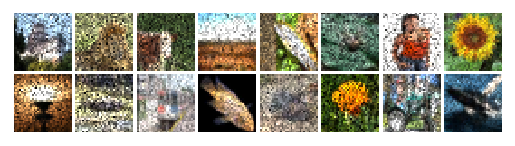

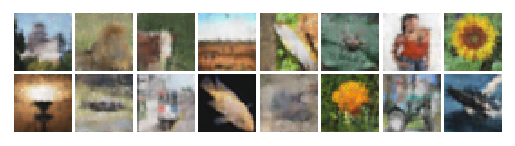

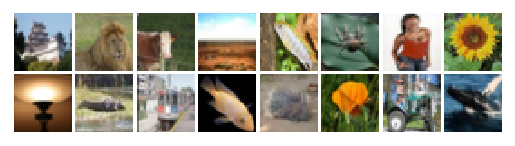

18000 train 0.04008162021636963 test 0.039170846343040466


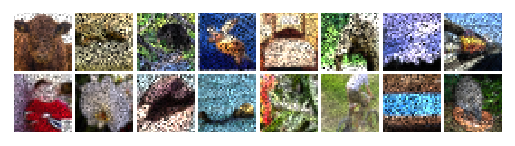

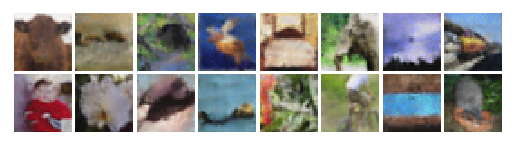

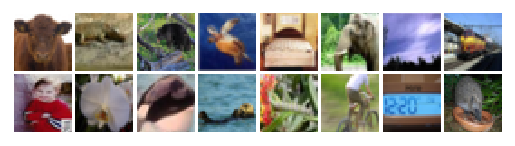

20000 train 0.04189227148890495 test 0.03938719257712364


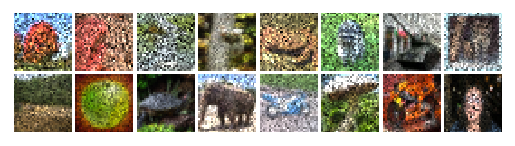

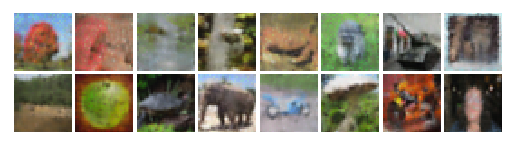

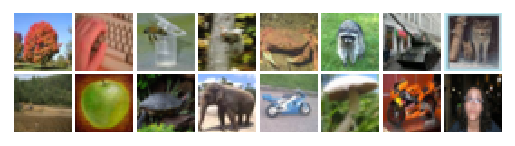

22000 train 0.042487844824790955 test 0.03733518347144127


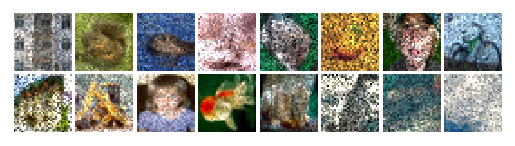

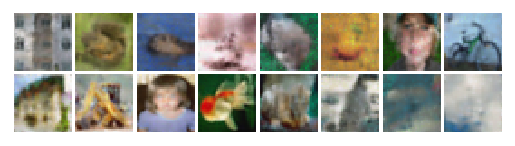

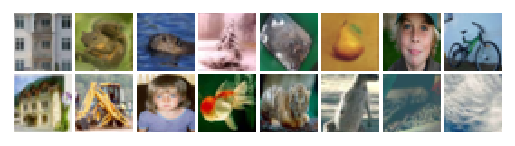

24000 train 0.03850588947534561 test 0.03357630595564842


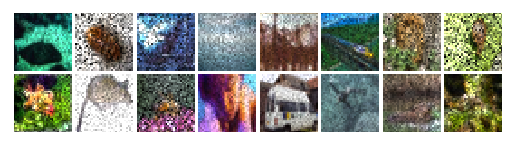

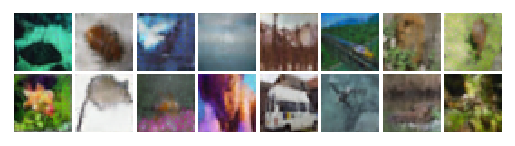

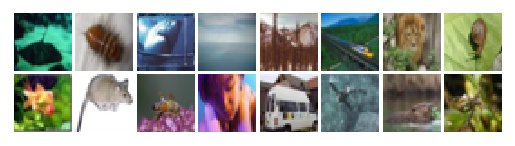

26000 train 0.035472072660923004 test 0.041976988315582275


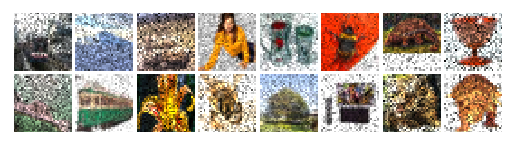

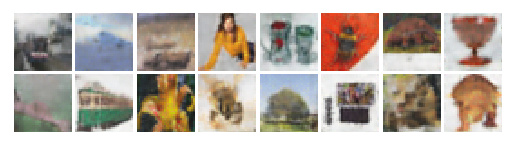

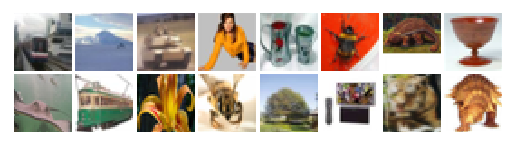

28000 train 0.03907349333167076 test 0.04252691566944122


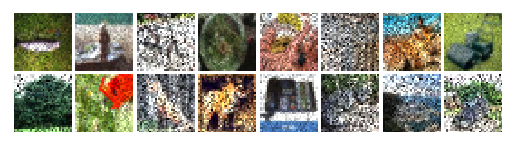

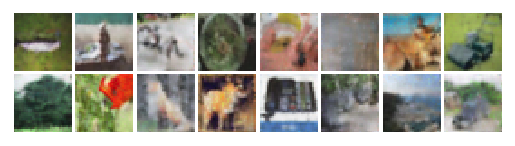

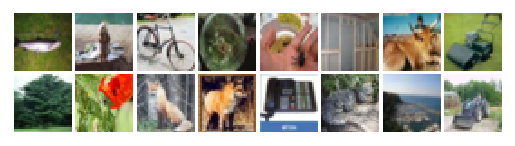

30000 train 0.03780272603034973 test 0.0437876433134079


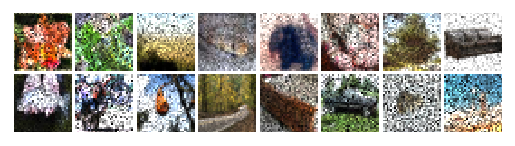

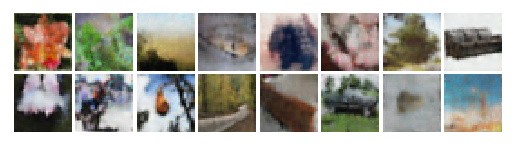

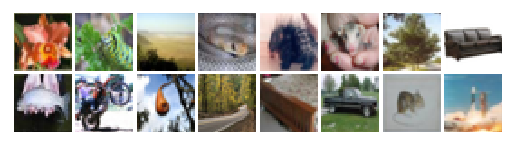

In [5]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.0002
)

def lossfun(x, y):
    return torch.mean(torch.abs(y-x))

for epoch in range(5):
    trainloader = torch.utils.data.DataLoader(traindata, batch_size=16)
    for images, label in trainloader:
        images = images.to(device)
        noised = add_noise(images)
        optimizer.zero_grad()
        output = model(noised)
        loss = lossfun(output, images)
        loss.backward()
        optimizer.step()

        batch_count += 1
        if batch_count % 100 == 0:
            testloader = torch.utils.data.DataLoader(testdata, batch_size=16, shuffle=True)
            with torch.no_grad():
                for ref, label in testloader:
                    ref = ref.to(device)
                    noised = add_noise(ref)
                    denoised = model(noised)
                    testloss = lossfun(denoised, ref)
                    batch_counts.append(batch_count)
                    train_losses.append(loss.detach().item())
                    test_losses.append(testloss.item())
                    break
                if batch_count % 2000 == 0:
                    print(batch_count,
                          "train", loss.detach().item(),
                          "test", testloss.item())
                    plot_imgs(noised)
                    plot_imgs(denoised)
                    plot_imgs(ref)


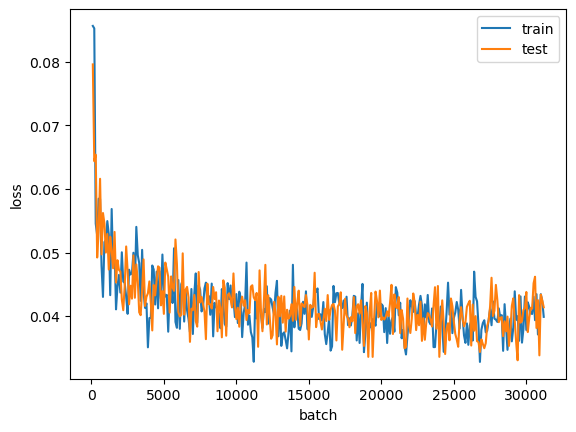

In [6]:
plt.plot(batch_counts, train_losses, label='train')
plt.plot(batch_counts, test_losses, label='test')
plt.legend()
plt.xlabel('batch')
plt.ylabel('loss')
plt.show()